# Purpose: Experimented with using Extreme Machine Learning to quickly retrain my model for each image, this turned out to not be very feasible due to the computational requirements of quickly generating training data for every image

In [24]:
from tensorflow.keras.models import load_model, Model
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import LinearStretch, ZScaleInterval, ImageNormalize
from astropy.io import fits
from astropy import wcs
import skimage
import random
import scipy.stats as stats
import pickle as pkl
from functools import partial
from multiprocessing import Pool
import cupy as cp
from cupyx.scipy.ndimage.filters import convolve
import tensorflow as tf
from tf_explain.core import GradCAM, SmoothGrad, IntegratedGradients, OcclusionSensitivity
import efficientnet.tfkeras as efn
import innvestigate
import reproject
import astroscrappy
import subprocess
import sep
from photutils import detect_threshold, detect_sources, deblend_sources, source_properties
from keras.backend.tensorflow_backend import set_session
import math
import os
from tqdm.notebook import tqdm
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image
import urllib.request
import tables
import scipy.stats

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

In [25]:
# generated from generate_streak_distribution.py
params_gamma_width = [4.79235037, 11.40523025, 1.64361626]
params_gamma_amplitude = [1.09717868, 1.99999993, 3.7169828]
params_gamma_length = [4.16396709, 8.0180058, 2.68969172]

gain = 6.2

size = 150
# min distance from center of streak to the edge of the crop
min_offset = 10
contrast = 0.35

bad_pix_max = 100

In [3]:
# size = 80
# step = 50
# model = load_model("/home/fwang/wandb/run-20200419_062135-rljo4afi/model-best_0.0004998333888703765_0.9704852426213106_0.9609805.h5")
# thresh = 0.9609805

# size = 80
# step = 50
# model = load_model("/home/fwang/wandb/run-20200519_194207-xixqjezt/model-best_0.0005714285714285715_0.9702380952380952_0.95495033.h5")
# thresh = 0.95495033

# note: this one is size = 200
# size = 200
# step = 150
# model = load_model("/home/fwang/wandb/run-20200603_183225-wedotq6j/model-best_0.00037142857142857143_0.9706666666666667_0.9968531.h5")
# # thresh = 0.9968531
# # the threshold is way too harsh, so set it to 0.99 instead
# thresh = 0.97

# size = 150
# step = 100
# thresh = 0.97370505
# model = load_model("/home/fwang/wandb/run-20200613_185519-1fonehu2/model-best_0.0008857142857142857_0.9700952380952381_0.97370505.h5")

# size = 150
# step = 100
# thresh = 0.98012877
# model = load_model("/home/fwang/wandb/run-20200625_053040-77dw3wdm/model-best_0.0007413647851727043_0.9703664700926706_0.98012877.h5")

size = 150
step = 100
thresh = 0.95
model = load_model("/home/fwang/wandb/run-20200627_210846-bz2nhb2v/model-best_0.00045492839090143216_0.9705981465880371_0.99692285.h5")

# size = 150
# step = 100
# thresh = 0.99
# model = load_model("/home/fwang/wandb/run-20200718_035504-q0giukcp/model-best_0.00038753159224936813_0.9705560235888795_0.99604964.h5")

In [4]:
def swarp_align(sci_file, ref_file, realign=False):
    ref, header = fits.getdata(ref_file, header=True)

    filename_sci = sci_file.split("/")[-1]
    directory = "/media/rd1/ztf_neos/pipeline/resampled/" + filename_sci[:-len(".fits")]

    try:
        os.makedirs(directory, exist_ok=realign)

    except FileExistsError:
        pass

    else:
        with open(directory + "/coadd.head", "w") as f:
            f.write(repr(header) + "\nEND     ")

        subprocess.run(["swarp", sci_file, "-c", "/home/fwang/Pipeline/swarp.conf", "-VERBOSE_TYPE", "QUIET"],
                       cwd=directory, stderr=subprocess.DEVNULL)

    return [fits.getdata(directory + "/coadd.fits"), ref]


def linear_regression(x, y, w):
    B = cp.matmul(x.T, cp.expand_dims(cp.multiply(w, y), -1))
    B2 = cp.linalg.inv(cp.matmul(x.T, cp.multiply(cp.expand_dims(w, -1), x)))
    return cp.matmul(B2, B)[..., 0]


def weighted_std(values, weights):
    average = cp.expand_dims(cp.average(values, weights=weights, axis=-1), -1)
    # Fast and numerically precise:
    variance = cp.average((values - average) ** 2, weights=weights, axis=-1)
    return cp.sqrt(variance)


# for some reason CuPy just doesn't have median function, this function takes in a presorted array
def get_median_sorted(arr):
    length = arr.shape[-1]
    return (arr[..., length // 2] + arr[..., (length - 1) // 2]) / 2


def normalize_cuda(arr, nsamples=size * size // 8, batch_size=1024):

    values = cp.reshape(arr, (len(arr), size * size))
    stride = (size * size) // nsamples
    
    for i in tqdm(list(range(int(math.ceil(len(arr) / batch_size))))):

        samples = cp.array(values[i * batch_size:(i + 1) * batch_size, ::stride][::, :nsamples])
        samples.sort()

        npix = nsamples
        nimage = len(samples)

        x = cp.arange(npix)
        x_fit = cp.stack((x, cp.ones(x.shape)), axis=-1)

        # pixels mask used in k-sigma clipping
        goodpix = cp.ones((nimage, npix))

        ngrow = max(1, int(npix * 0.01))
        kernel = cp.ones((1, ngrow))

        for niter in range(3):
            fit = linear_regression(x_fit, samples, goodpix)
            slope = fit[:, 0]
            intercept = fit[:, 1]

            fitted = cp.expand_dims(slope, 1) * cp.expand_dims(x, 0) + cp.expand_dims(intercept, 1)

            # Subtract fitted line from the data array
            flat = samples - fitted

            # Compute the k-sigma rejection threshold
            threshold = cp.expand_dims(2.5 * weighted_std(flat, goodpix), -1)

            # Detect and reject pixels further than k*sigma from the
            # fitted line
            goodpix[(flat < - threshold) | (flat > threshold)] = 0

            goodpix = 1 - cp.clip(convolve(1 - goodpix, kernel), 0, 1)

        if contrast > 0:
            slope = slope / contrast
        center_pixel = (npix - 1) // 2
        median = get_median_sorted(samples)

        vmin = median - (center_pixel - 1) * slope
        vmax = median + (npix - center_pixel) * slope

        old_min = cp.min(samples, axis=1)
        old_max = cp.max(samples, axis=1)

        vmin = cp.maximum(vmin, old_min)
        vmax = cp.minimum(vmax, old_max)

        vmin = cp.reshape(vmin, (len(samples), 1, 1))
        vmax = cp.reshape(vmax, (len(samples), 1, 1))

        arr_batch = arr[i * batch_size:(i + 1) * batch_size]
        
        arr_batch -= vmin
        arr_batch /= vmax - vmin
        
        arr[i * batch_size:(i + 1) * batch_size] = cp.clip(arr_batch, 0, 1)

        sorted_arr = cp.sort(cp.reshape(arr_batch, (len(arr_batch), 1, -1)))

        median_arr = cp.expand_dims(get_median_sorted(sorted_arr), -1)

        # makes more sense to use median due to large number of outliers
        arr[i * batch_size:(i + 1) * batch_size] = (arr_batch - median_arr) / cp.std(arr_batch, axis=(1, 2), keepdims=True)

    return arr

def normalize(arr, samples=size * size // 8):
    arr = np.copy(arr)
    vmin, vmax = ZScaleInterval(samples).get_limits(arr)
    arr -= vmin
    arr /= vmax - vmin
    arr = np.clip(arr, 0, 1)

    return (arr - np.median(arr, axis=(0, 1), keepdims=True)) / np.std(arr, axis=(0, 1), keepdims=True)

In [5]:
def check_image(arr):
    return arr.shape == (size, size) \
           and np.count_nonzero(arr == arr[0][size//2]) < bad_pix_max \
           and np.count_nonzero(arr == arr[size-1][size//2]) < bad_pix_max \
           and np.count_nonzero(arr == arr[size//2][0]) < bad_pix_max \
           and np.count_nonzero(arr == arr[size-1][size//2]) < bad_pix_max \
           and np.count_nonzero(arr == 0) < bad_pix_max \
           and np.count_nonzero(~np.isfinite(arr)) < bad_pix_max


def generate_streak(x_size, y_size, x_center, y_center, angle, amplitude, length, psf_width):
    x = np.arange(0, x_size)
    y = np.expand_dims(np.arange(0, y_size), -1)

    hx = (x - x_center) * math.cos(angle) - (y - y_center) * math.sin(angle)
    hy = (x - x_center) * math.sin(angle) + (y - y_center) * math.cos(angle)

    arr = np.exp(-hy ** 2 / (2 * psf_width ** 2)) * \
          (scipy.special.erf((hx + length / 2) / (psf_width * np.sqrt(2))) -
           scipy.special.erf((hx - length / 2) / (psf_width * np.sqrt(2))))

    arr *= amplitude / np.max(arr)

    return arr, arr > amplitude / 200


def select_random_section(sci, ref):
    y_len, x_len = sci.shape
#     x = np.random.randint(0, x_len - size)
#     y = np.random.randint(0, y_len - size)
    x = np.random.randint(0, (x_len // step) - 2)
    y = np.random.randint(0, (y_len // step) - 2)
    
    x *= step
    y *= step

    return sci[y:y+size, x:x+size], ref[y:y+size, x:x+size]


def implant_random_streak(image, return_info=False, predetermined_vals=False, streak=None, mask=None, factor=None, bkg=None):

    image = np.array(image, dtype=np.float32)

    while True:
        if np.random.random() < 0.8:
            std = stats.gamma.rvs(*params_gamma_width) * 0.05
        else:
            # fatter streaks
            std = 1.5 + 2 * np.abs(np.random.randn())

        if np.random.random() < 0.5:
            # based on the collected distribution (not below 10 however)
            length = stats.gamma.rvs(*params_gamma_length)
        elif np.random.random() < 0.8:
            # short streaks
            length = np.random.random() * 4 + 7
        else:
            # long streaks
            length = np.random.random() * 40 + 10

        if length > 4 and std > 0.5:
            break

    if not predetermined_vals:

        x = np.random.randint(min_offset, size - min_offset)
        y = np.random.randint(min_offset, size - min_offset)

        rotation = np.random.random() * np.pi * 2

        streak, mask = generate_streak(size, size, x, y, rotation, 1, length, std)

        if np.random.random() < 0.8:
            factor = 1 + np.abs(np.random.randn()) * 0.5
        else:
            factor = np.random.random() * 2 + 2

    # if bkg is None:
    #     bkg = sep.Background(image)
    # amp_min = np.percentile(np.abs(bkg.back()[mask] - image[mask]), 68) * 3
    amp_min = np.std(image[mask]) * 3

    if std > 2.2 or length < 9:
        amp_min *= 3.9/3

    streak_scaled = streak * factor * amp_min
    streak_scaled = np.random.poisson(streak_scaled * gain) / gain

    if return_info:
        return image + streak_scaled, (x, y, rotation, length, std, streak, mask, factor, amp_min)

    return image + streak_scaled

In [75]:
num_negative_images = 600
num_hard_neg_images = 400
num_positive_images = 500

def implant_random_streak_file(sci_file, ref_file):

    sci, ref = swarp_align(sci_file, ref_file)

    # make sure not too many values are equal to zero (empty sections of images)
    # make sure images are the right size and are typical images

    # result[0] is the negative images, result[1] is the positive images
    result = []
    streak_metadata = []
    
    print("Negative Images")

    for _ in tqdm(list(range(num_negative_images))):
        while True:
            sci_crop, ref_crop = select_random_section(sci, ref)

            if check_image(sci_crop) and check_image(ref_crop):
                break

        bkg_sci = None
        if np.sum(~np.isfinite(sci_crop)) > 0:
            bkg_sci = sep.Background(np.array(sci_crop, dtype=np.float32))
            sci_crop[~np.isfinite(sci_crop)] = bkg_sci.globalback

        bkg_ref = None
        if np.sum(~np.isfinite(ref_crop)) > 0:
            bkg_ref = sep.Background(np.array(ref_crop, dtype=np.float32))
#             ref_crop[~np.isfinite(ref_crop)] = bkg_ref.globalback
            ref_crop[~np.isfinite(ref_crop)] = 100000

        sci_crop = astroscrappy.detect_cosmics(sci_crop)[1]

        result.extend([sci_crop, ref_crop])
        streak_metadata.append({})

    print("Hard Negative Images")
    
    for _ in tqdm(list(range(num_hard_neg_images))):
        while True:
            sci_crop, ref_crop = select_random_section(sci, ref)

            if check_image(sci_crop) and check_image(ref_crop):
                break

        bkg_sci = None
        if np.sum(~np.isfinite(sci_crop)) > 0:
            bkg_sci = sep.Background(np.array(sci_crop, dtype=np.float32))
            sci_crop[~np.isfinite(sci_crop)] = bkg_sci.globalback

        bkg_ref = None
        if np.sum(~np.isfinite(ref_crop)) > 0:
            bkg_ref = sep.Background(np.array(ref_crop, dtype=np.float32))
            ref_crop[~np.isfinite(ref_crop)] = 100000

        sci_crop = astroscrappy.detect_cosmics(sci_crop)[1]

        sci_crop_streak, (x_streak, y_streak, rotation, length, std, streak, mask, factor, amp_min) = implant_random_streak(sci_crop, return_info=True, bkg=bkg_sci)
        ref_crop_streak = implant_random_streak(ref_crop, predetermined_vals=True, streak=streak, mask=mask, factor=factor, bkg=bkg_ref)

        streak_metadata.append({
            "x": x_streak,
            "y": y_streak,
            "amp_min": amp_min,
            "factor": factor,
            # "streak_arr_normalized": streak,
            # "mask": mask,
            "length": length,
            "rotation": rotation,
            "width": std,
            "hard_neg": True,
            "sci_file": sci_file,
            "ref_file": ref_file,
        })

        result.extend([sci_crop_streak, ref_crop_streak])

    print("Positive Images")
                  
    for _ in tqdm(list(range(num_positive_images))):
        while True:
            sci_crop, ref_crop = select_random_section(sci, ref)

            if check_image(sci_crop) and check_image(ref_crop):
                break

        bkg_sci = None
        if np.sum(~np.isfinite(sci_crop)) > 0:
            bkg_sci = sep.Background(np.array(sci_crop, dtype=np.float32))
            sci_crop[~np.isfinite(sci_crop)] = bkg_sci.globalback

        bkg_ref = None
        if np.sum(~np.isfinite(ref_crop)) > 0:
            bkg_ref = sep.Background(np.array(ref_crop, dtype=np.float32))
            ref_crop[~np.isfinite(ref_crop)] = 100000

        sci_crop = astroscrappy.detect_cosmics(sci_crop)[1]

        sci_crop_streak, (x_streak, y_streak, rotation, length, std, streak, mask, factor, amp_min) = implant_random_streak(sci_crop, return_info=True, bkg=bkg_sci)

        result.extend([sci_crop_streak, ref_crop])

        streak_metadata.append({
            "x": x_streak,
            "y": y_streak,
            "amp_min": amp_min,
            "factor": factor,
            # "streak_arr_normalized": streak,
            # "mask": mask,
            "length": length,
            "rotation": rotation,
            "width": std,
            "hard_neg": True,
            "sci_file": sci_file,
            "ref_file": ref_file,
        })
                  
    print("CUDA Normalization")

    images = cp.array(result, dtype=cp.float32)
    results = normalize_cuda(images).get()
    results = np.reshape(results, (len(images) // 2, 2, size, size))
    results = np.transpose(results, (0, 2, 3, 1))
#     results = results.get()

    return results, streak_metadata

In [7]:
def display_triplet(pair, title=None, normalized=True):
    if not normalized:
        pair[0] = normalize(pair[0])
        pair[1] = normalize(pair[1])
    plt.figure(figsize=(10, 3))
    if title is not None:
        plt.suptitle(title)
    plt.subplot(1, 3, 1)
    plt.imshow(pair[0], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.imshow(pair[1], cmap="gray")
    plt.subplot(1, 3, 3)
    pair_input = np.transpose([pair], (0, 2, 3, 1))
    outputs, guided_grads = GradCAM.get_gradients_and_filters(model, pair_input, "conv2d_2", 0)
    cam = GradCAM.generate_ponderated_output(outputs, guided_grads)
    plt.imshow(cam[0], cmap="inferno")

In [8]:
# loading the real data filenames
with open("/home/fwang/savelinksztfvisiblemetadata.pkl", "rb") as f:
    metadata = pkl.load(f)

In [9]:
filenames = glob.glob("/mnt/etdisk9/ztf_neos/ztf_visible/science/*.fits")

In [96]:
sci = filenames[20]
ref = metadata[sci.split("/")[-1]]["ref_file"]
# sci, ref = arguments[20]

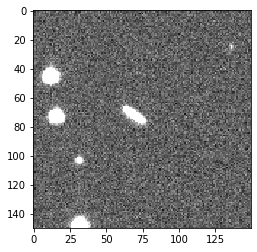

In [97]:
ra = metadata[sci.split("/")[-1]]["ra"]
dec = metadata[sci.split("/")[-1]]["dec"]
wcs_sci = wcs.WCS(sci)
pix = wcs_sci.all_world2pix([[ra, dec]], 0, ra_dec_order=True)[0]
pix = list(map(int, pix))
sci_img = fits.getdata(sci)
plt.imshow(normalize(sci_img[pix[1] - size//2:pix[1] + size//2, pix[0] - size//2:pix[0] + size//2]), cmap="gray")

In [98]:
results, metadata_streaks = implant_random_streak_file(sci, ref)

Negative Images



Hard Negative Images



Positive Images



CUDA Normalization


In [99]:
labels = np.array([-1] * (num_negative_images + num_hard_neg_images) + [1] * num_positive_images)

In [100]:
model_vector = Model(inputs=model.inputs, outputs=model.layers[-4].output)

In [101]:
vectors = model_vector.predict(results, batch_size=32)

In [102]:
vectors = np.append(vectors, np.ones((len(vectors), 1)), axis=1)

In [103]:
vectors_pinv = cp.linalg.pinv(cp.array(vectors, dtype=cp.float64)).get()

In [104]:
weights = np.dot(vectors_pinv, labels)

In [105]:
outputs = np.dot(vectors, weights)

In [106]:
indicies = np.where(np.logical_and(outputs > 0, labels == -1))[0]

In [107]:
for i in range(len(indicies)):
    display_triplet(np.transpose(results[indicies[i]], [2, 0, 1]), title=outputs[indicies[i]])

In [117]:
def process_images(sci_file, ref_file, threshold=0.5, batch_size=2048, align=True, verbose=False, clean_sat=False, use_extreme=True):
    
    if align:
        sci, ref = swarp_align(sci_file, ref_file)
    else:
        sci = sci_file
        ref = ref_file
    
    y_len, x_len = sci.shape
    images = []
    bounds = []
    for i in range(0, y_len, step):
        for j in range(0, x_len, step):
            if j + size >= x_len or i + size >= y_len:
                continue

            crop_sci = sci[i:i+size, j:j+size]
            crop_ref = ref[i:i+size, j:j+size]

            if np.sum(np.abs(crop_sci) == 0) >= 100 or np.sum(np.abs(crop_ref) == 0) >= 100 or np.sum(np.isnan(crop_sci)) > 100 or np.sum(np.isnan(crop_ref)) > 100:
                continue
            
            crop_ref[~np.isfinite(crop_ref)] = 100000
            crop_sci[~np.isfinite(crop_sci)] = 0

            images.append([crop_sci, crop_ref])
            bounds.append([[j, i],[j+size, i+size]])

    
    images = np.array(images)
    
    images_gpu = cp.array(images, dtype=cp.float32)
    images_gpu = cp.reshape(images_gpu, (-1, size, size))
    

    norm_images = normalize_cuda(images_gpu, size * size // 8)

    norm_images = cp.reshape(norm_images, (-1, 2, size, size)).get()
    
    norm_images_transpose = np.transpose(norm_images, [0, 2, 3, 1])

    if use_extreme:
        
        vectors = model_vector.predict(norm_images_transpose, batch_size=batch_size)
        vectors = np.append(vectors, np.ones((len(vectors), 1)), axis=1)
        preds = np.dot(vectors, weights)
        indexes = preds > 0.1
    
    else:
        
        preds = model.predict(norm_images_transpose, batch_size=batch_size)[:, 0]

        indexes = preds > threshold
    
    top_images = images[indexes]
    top_bounds = np.array(bounds)[indexes]
#     print(top_images)
#     plt.imshow(normalize(top_images[0][0]), cmap="gray")
#     plt.figure()
#     plt.imshow(normalize(top_images[0][1]), cmap="gray")

#     valid_indexes = check_images(top_images)
#     top_images = top_images[valid_indexes]
#     top_bounds = top_bounds[valid_indexes]
    
    if verbose:

        print(np.sort(preds))
        print(top_images)

        print(bounds[np.argsort(preds)[::-1][0]])
        plt.imshow(norm_images[np.argsort(preds)[::-1][0]][0], cmap="gray")
        plt.figure()
        plt.imshow(norm_images[np.argsort(preds)[::-1][0]][1], cmap="gray")
        plt.figure()

        plt.imshow(norm_images[np.argsort(preds)[::-1][1]][0], cmap="gray")
        plt.figure()
        plt.imshow(norm_images[np.argsort(preds)[::-1][1]][1], cmap="gray")
        plt.figure()
    

    if len(top_images) > 0:
    
        clean_images = []

        for (sci, ref), bounds in zip(top_images, top_bounds):
            cleaned_cosmics_sci = astroscrappy.detect_cosmics(sci)[1]
            if not clean_sat:
                clean_images.append([cleaned_cosmics_sci, ref])
                continue
            try:
                cleaned, mask = clean_saturation_artifacts(cleaned_cosmics_sci, sci_file, ref_file, bounds)
                clean_images.append([cleaned, ref])
            except FileNotFoundError:
                clean_images.append([cleaned_cosmics_sci, ref])
                print(sci_file, ref_file, bounds)
        
        images_gpu = cp.array(clean_images, dtype=cp.float32)
        images_gpu = cp.reshape(images_gpu, (-1, size, size))

        norm_images = normalize_cuda(images_gpu, size * size // 8)
        norm_images = cp.reshape(norm_images, (-1, 2, size, size)).get()

        norm_images_transpose = np.transpose(norm_images, [0, 2, 3, 1])


        if use_extreme:
        
            vectors = model_vector.predict(norm_images_transpose, batch_size=batch_size)
            vectors = np.append(vectors, np.ones((len(vectors), 1)), axis=1)
            preds = np.dot(vectors, weights)
            print(preds)
            indexes = preds > 0
    
        else:

            preds = model.predict(norm_images_transpose, batch_size=batch_size)[:, 0]

            indexes = preds > threshold
        
        if verbose:
            plt.imshow(norm_images[indexes][0][0], cmap="gray")
            plt.figure()
            plt.imshow(norm_images[indexes][0][1], cmap="gray")
        
        return top_images[indexes], norm_images[indexes], preds[indexes], top_bounds[indexes]

    return [], [], [], []

In [118]:
top_images, norm_images, preds, top_bounds = process_images(sci, ref, batch_size=1)


[ 0.17171482 -1.0025752 ]


In [120]:
display_triplet(norm_images[1])

IndexError: index 1 is out of bounds for axis 0 with size 1

[0.17171482]


IndexError: index 1 is out of bounds for axis 0 with size 1

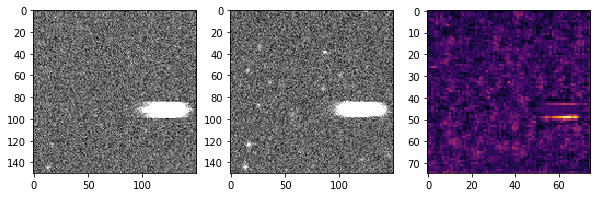

In [113]:
print(preds)
display_triplet(norm_images[0])
display_triplet(norm_images[1])
display_triplet(norm_images[2])
display_triplet(norm_images[3])
display_triplet(norm_images[4])

In [114]:
top_images, norm_images, preds, top_bounds = process_images(sci, ref, batch_size=1, use_extreme=False, threshold=0.95)

In [115]:
print(len(preds))

1


In [116]:
print(sci)

/mnt/etdisk9/ztf_neos/ztf_visible/science/ztf_20180325358403_000718_zg_c06_o_q4_sciimg.fits


In [66]:
# the "one day" data
def convert_sci_to_ref_test(file):
    info = file.split("_")[2:-1]
    return "/mnt/etdisk9/ztf_neos/pipeline/reference/ztf_" + "_".join(info[1:4] + info[5:6]) + "_refimg.fits"

filenames_test = glob.glob("/mnt/etdisk9/ztf_neos/pipeline/science/*.fits")
filename_test_pairs = [(file, convert_sci_to_ref_test(file)) for file in filenames_test]

In [388]:
arguments = []
for pair in tqdm(filename_test_pairs):
    if os.path.exists(pair[0]) and os.path.exists(pair[1]):
        arguments.append(pair)

In [435]:
i = 2
top_images, norm_images, preds, top_bounds = process_images(*arguments[i], batch_size=1, use_extreme=False, threshold=0.95)

In [436]:
print(len(preds))

1


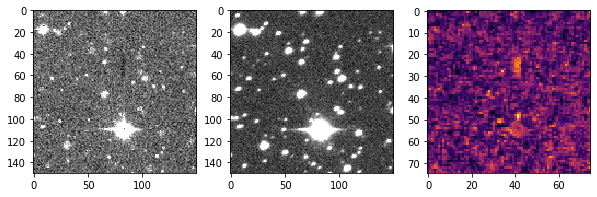

In [437]:
display_triplet(norm_images[0])